## Import Libraries

In [3]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

## Data Download

In [4]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-08-01 18:26:54--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  19.8MB/s    in 0.4s    

2024-08-01 18:26:54 (19.8 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [5]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset
License(s): ODbL-1.0
100% 2.53G/2.54G [00:31<00:00, 131MB/s]
100% 2.54G/2.54G [00:31<00:00, 87.6MB/s]


In [ ]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

In [ ]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [6]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [7]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

In [8]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [9]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [10]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [11]:
split_dataset=text_dataset.map(selector)

In [12]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [13]:
init_dataset=text_dataset.map(separator)

In [14]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [15]:
for i in init_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va ! endtoken'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche. endtoken'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route ! endtoken'], dtype=object)>)


In [16]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [17]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y,z and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [18]:
print(len(english_vectorize_layer.get_vocabulary()))
print(len(french_vectorize_layer.get_vocabulary()))

16952
20000


In [19]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [20]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [21]:
dataset=split_dataset.map(vectorizer)

In [22]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [23]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [24]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [25]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [27]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [28]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [29]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
len(dataset)

# Modeling

In [30]:
NUM_UNITS=256

In [31]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 64, 300)        │      6,000,000 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 64, 300)        │      6,000,000 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512)            │        857,088 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 64, 512)        │      1,250,304 │ embedding_1[0][0],     │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 512)        │              0 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 20000)      │     10,260,000 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,367,392 (92.95 MB)

 Trainable params: 24,367,392 (92.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [32]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    metrics=["accuracy"])
    #metrics=[BLEU()],
    #run_eagerly=True)

In [34]:
checkpoint_filepath = '/content/drive/MyDrive/Translation/gru.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
   2812/Unknown 529s 185ms/step - accuracy: 0.9395 - loss: 0.6179

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2812/2812 ━━━━━━━━━━━━━━━━━━━━ 638s 224ms/step - accuracy: 0.9395 - loss: 0.6178 - val_accuracy: 0.8874 - val_loss: 0.6968
Epoch 2/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 668s 237ms/step - accuracy: 0.9603 - loss: 0.2257 - val_accuracy: 0.8989 - val_loss: 0.6058
Epoch 3/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 683s 238ms/step - accuracy: 0.9664 - loss: 0.1723 - val_accuracy: 0.9049 - val_loss: 0.5571
Epoch 4/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 686s 239ms/step - accuracy: 0.9702 - loss: 0.1424 - val_accuracy: 0.9078 - val_loss: 0.5464
Epoch 5/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 642s 225ms/step - accuracy: 0.9727 - loss: 0.1232 - val_accuracy: 0.9102 - val_loss: 0.5307
Epoch 6/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 675s 223ms/step - accuracy: 0.9746 - loss: 0.1099 - val_accuracy: 0.9116 - val_loss: 0.5220
Epoch 7/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 678s 221ms/step - accuracy: 0.9760 - loss: 0.1002 - val_accuracy: 0.9120 - val_loss: 0.5243
Epoch 8/10
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 722s 236ms/step - accuracy: 0.9

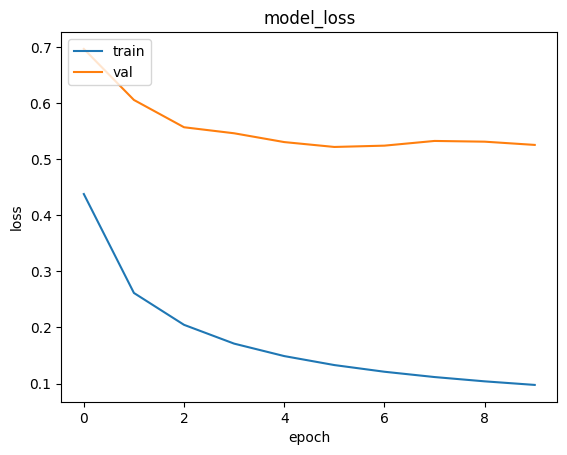

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

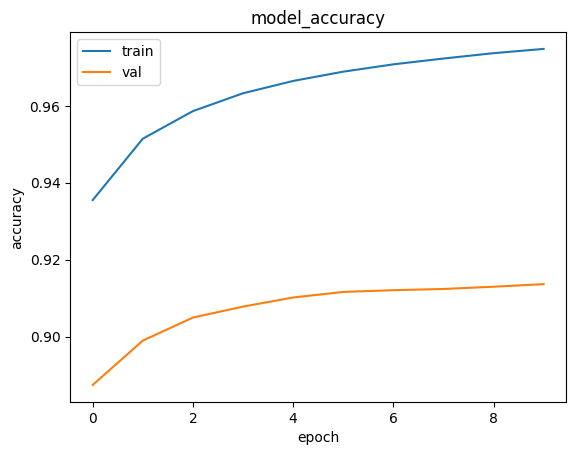

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [39]:
seq2seq_gru.evaluate(val_dataset)

825/825 ━━━━━━━━━━━━━━━━━━━━ 109s 78ms/step - accuracy: 0.9398 - loss: 0.3239


[0.5256883502006531, 0.9136162400245667]

## Testing

In [40]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [41]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [42]:
translator('What makes you think that is not true?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'questce qui te fait croire que tu nes pas fait'

In [45]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}